In [1]:
# STEP 1: IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
import joblib


In [2]:
# STEP 2: LOAD DATA
df = pd.read_csv("D:\\Data Science\\customer_churn_data.csv")
df.head()


,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,Male,4,88.35,Month-to-Month,Fiber Optic,353.40,Yes,Yes
1,2,43,Male,0,36.67,Month-to-Month,Fiber Optic,0.00,Yes,Yes
2,3,51,Female,2,63.79,Month-to-Month,Fiber Optic,127.58,No,Yes
3,4,60,Female,8,102.34,One-Year,DSL,818.72,Yes,Yes
4,5,42,Male,32,69.01,Month-to-Month,NaN,2208.32,No,Yes


In [3]:
# STEP 3: CLEAN DATA
df["InternetService"] = df["InternetService"].fillna("")
df.drop_duplicates(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       1000 non-null   int64  
 1   Age              1000 non-null   int64  
 2   Gender           1000 non-null   object 
 3   Tenure           1000 non-null   int64  
 4   MonthlyCharges   1000 non-null   float64
 5   ContractType     1000 non-null   object 
 6   InternetService  1000 non-null   object 
 7   TotalCharges     1000 non-null   float64
 8   TechSupport      1000 non-null   object 
 9   Churn            1000 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 78.3+ KB


In [4]:
# STEP 4: FEATURE ENGINEERING
X = df[["Age","Gender","MonthlyCharges","Tenure",
         "ContractType","InternetService","TechSupport","TotalCharges"]].copy()

# Encode Gender
X["Gender"] = X["Gender"].apply(lambda x: 1 if x=="Female" else 0)

# One Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Target
y = df["Churn"].apply(lambda x: 1 if x=="Yes" else 0)

X.head()


,Age,Gender,MonthlyCharges,Tenure,TotalCharges,ContractType_One-Year,ContractType_Two-Year,InternetService_DSL,InternetService_Fiber Optic,TechSupport_Yes
0,49,0,88.35,4,353.40,False,False,False,True,True
1,43,0,36.67,0,0.00,False,False,False,True,True
2,51,1,63.79,2,127.58,False,False,False,True,False
3,60,1,102.34,8,818.72,True,False,True,False,True
4,42,0,69.01,32,2208.32,False,False,False,False,False


In [5]:
# STEP 5: STRATIFIED SPLIT
x_train, x_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42,
    stratify = y
)

print("Train:", x_train.shape)
print("Test :", x_test.shape)


Train: (800, 10)
Test : (200, 10)


In [6]:
# STEP 6: SMOTE
sm = SMOTE()
x_train, y_train = sm.fit_resample(x_train, y_train)


In [7]:
# STEP 7: SCALING
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [8]:
# STEP 8: MODEL TRAINING

# Logistic Regression
log_model = LogisticRegression(class_weight="balanced", max_iter=500)
log_model.fit(x_train, y_train)
y_pred_log = log_model.predict(x_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred_log))
print("AUC =", roc_auc_score(y_test, log_model.predict_proba(x_test)[:,1]))


Logistic Regression
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        23
           1       0.99      0.98      0.98       177

    accuracy                           0.97       200
   macro avg       0.91      0.95      0.93       200
weighted avg       0.97      0.97      0.97       200

AUC = 0.9960697617293048


In [9]:
# KNN + GridSearch
param_grid_knn = {
    "n_neighbors":[3,5,7,9],
    "weights":["uniform","distance"]
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_knn.fit(x_train, y_train)

y_pred_knn = grid_knn.predict(x_test)

print("KNN Best Params:", grid_knn.best_params_)
print(classification_report(y_test, y_pred_knn))


KNN Best Params: {'n_neighbors': 3, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        23
           1       0.99      0.97      0.98       177

    accuracy                           0.96       200
   macro avg       0.90      0.94      0.92       200
weighted avg       0.97      0.96      0.97       200



In [10]:
# SVM + GridSearch
param_grid_svm = {
    "C":[0.01,0.1,0.5,1],
    "kernel":["linear","rbf","poly"],
    "gamma":["scale","auto"]
}

gridsvc = GridSearchCV(SVC(probability=True, class_weight="balanced"), param_grid_svm, cv=5)
gridsvc.fit(x_train, y_train)

y_pred_svm = gridsvc.predict(x_test)

print("SVM Best Params:", gridsvc.best_params_)
print(classification_report(y_test, y_pred_svm))


SVM Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        23
           1       1.00      0.98      0.99       177

    accuracy                           0.98       200
   macro avg       0.94      0.99      0.97       200
weighted avg       0.99      0.98      0.99       200



In [11]:
# Random Forest
rf = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))


Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       177

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [12]:
# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)
y_pred_gb = gb.predict(x_test)

print("Gradient Boosting")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       177

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [13]:
from sklearn.metrics import f1_score

models = {
    "Logistic": (y_pred_log, log_model),
    "KNN": (y_pred_knn, grid_knn.best_estimator_),
    "SVM": (y_pred_svm, gridsvc.best_estimator_),
    "RandomForest": (y_pred_rf, rf),
    "GradientBoosting": (y_pred_gb, gb)
}

best = None
best_score = 0

for name,(pred,model) in models.items():
    score = f1_score(y_test,pred)
    print(name,"F1 Score =>",score)
    
    if score > best_score:
        best_score = score
        best = model

print("\nBEST MODEL =", best)
joblib.dump(best,"best_model.pkl")


Logistic F1 Score => 0.9829545454545454
KNN F1 Score => 0.98005698005698
SVM F1 Score => 0.9914529914529915
RandomForest F1 Score => 1.0
GradientBoosting F1 Score => 1.0

BEST MODEL = RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)


['best_model.pkl']

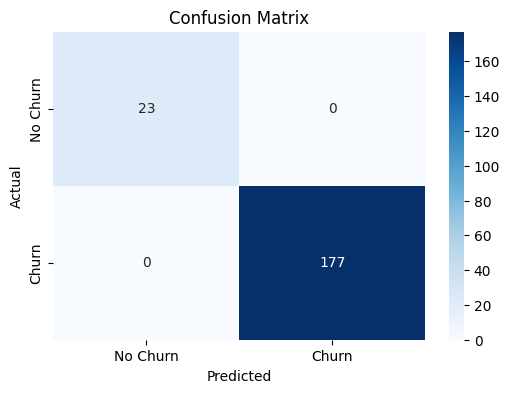

In [14]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn','Churn'],
            yticklabels=['No Churn','Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


AUC = 1.0


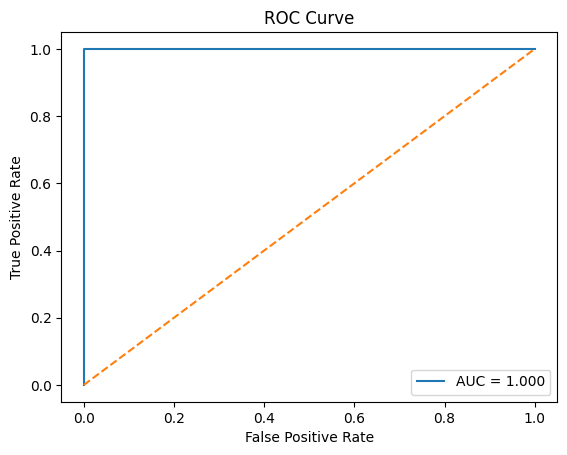

In [15]:
proba = rf.predict_proba(x_test)[:,1]
auc = roc_auc_score(y_test, proba)
print("AUC =", auc)

fpr, tpr, _ = roc_curve(y_test, proba)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [16]:
thresholds = np.arange(0.1, 0.9, 0.05)
best_f1 = 0
best_t = 0.5

from sklearn.metrics import f1_score

for t in thresholds:
    tuned_pred = (proba > t).astype(int)
    score = f1_score(y_test, tuned_pred)
    
    if score > best_f1:
        best_f1 = score
        best_t = t

print("Best Threshold =", best_t)
print("Best F1 =", best_f1)


Best Threshold = 0.40000000000000013
Best F1 = 1.0


In [17]:
y_pred_final = (proba > best_t).astype(int)

print("FINAL MODEL REPORT")
print(classification_report(y_test, y_pred_final))

print("CONFUSION MATRIX")
print(confusion_matrix(y_test, y_pred_final))

print("AUC =", roc_auc_score(y_test, proba))


FINAL MODEL REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       177

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

CONFUSION MATRIX
[[ 23   0]
 [  0 177]]
AUC = 1.0


In [19]:
print("Contract Type")
print(pd.crosstab(df["ContractType"], y))


Contract Type
Churn            0    1
ContractType           
Month-to-Month   0  511
One-Year        71  218
Two-Year        46  154


In [20]:
print("Tech Support")
print(pd.crosstab(df["TechSupport"], y))


Tech Support
Churn          0    1
TechSupport          
No             0  494
Yes          117  389


In [21]:
print("Internet Service")
print(pd.crosstab(df["InternetService"], y))


Internet Service
Churn             0    1
InternetService         
                  0  297
DSL              48  260
Fiber Optic      69  326


In [22]:
df["TenureGroup"] = pd.cut(df["Tenure"], bins=[0,1,12,24,48,200],
                           labels=["0-1","1-12","12-24","24-48","48+"])

print("Tenure Group")
print(pd.crosstab(df["TenureGroup"], y))


Tenure Group
Churn         0    1
TenureGroup         
0-1           0   55
1-12          4  380
12-24        54  179
24-48        42  149
48+          17   69
